In [13]:
# Eroding Coastlines: A GeoSpatial and Computer Vision Analysis

# This notebook shows the process of importing a satellite data, analyzing raster data, and computing NDWI to identify change of coastline overtime. 

# In this notebook, we will be analyzing a pretty severe example of coastal erosion. To do so we will:

#1. Extract data from multi-band imagery
#2. Compute the normalized difference water index (NDWI)
#3. Use NDWI to identify which pixels are associated to water and which pixels are associated with land
#4. Use classical image processing and computer vision techniques to analyze coastal erosion within the area of interest (AOI)


#This AOI and analysis has been inspired by a the following paper: Crawford, T.W. et al., Coastal Erosion and Human Perceptions of Revetment Protection in the Lower Meghna Estuary of Bangladesh. Remote Sens. 2020, 12, 3108. https://doi.org/10.3390/rs12183108

# Prerequisites
# Install: rasterio library
# Download data: https://hello.planet.com/data/s/Y2wFKNFNTwHxot8 (This is the data for the AOI, which has already been processed, mosaiced, and hosted.)




In [14]:
%pip install wget
%pip install rasterio
# %pip install opencv-contrib-python
%pip install matplotlib
%pip install scipy



You are using pip version 10.0.1, however version 22.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You are using pip version 10.0.1, however version 22.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You are using pip version 10.0.1, however version 22.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You are using pip version 10.0.1, however version 22.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [15]:
!wget -q -O tmp.zip https://hello.planet.com/data/s/Y2wFKNFNTwHxot8/download/scipy2022_workshop_data.zip && unzip tmp.zip && rm tmp.zip

/bin/bash: wget: command not found


In [16]:
from glob import glob

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# import cv2

%matplotlib inline

ModuleNotFoundError: No module named 'cv2'

# Retrieve data

Within our data folder, labeled scipy2022_workshop_data, we have both Analytic Surface Reflectance images and Visual images. While these images reflect the same AOI, they are used for different purposes. The visual images are colour-corrected and intended to be viewed and analyzed by the human eye, while the analytical images are orthorectified, radiometrically-calibrated, and are stored as 16-bit scaled radiance, which are intended to be used for scientific purposes. You may find out more on our Dev Center.

Let's retrieve both the multi-band and visual-band images across our entire time of interest (2017 - 2022), then sort the data to be chronological.

The AOI encapsulates a small, 7 km (4.4 mi) long, coastal region in Kamalnagar, Chittagong, Bangladesh, which is located in Southern Bangladesh, where the ocean (Bay of Bengal) meets a major inlet, the Meghna River. We have chosen to image the AOI once each spring to analyze.

Let's retrieve visual and color-corrected imagery! 

In [ ]:
# The base directory which holds all of the imagery
data_directory = "scipy2022_workshop_data"

# Find all relevant files from the folder
analytic_filenames = glob(data_directory + "/*analytic/composite.tif")
visual_filenames = glob(data_directory + "/*visual/composite.tif")

# Sort the file chronologically, from 2017 to 2022
analytic_filenames.sort()
visual_filenames.sort()

print(analytic_filenames)


Now, we're going to create an image processing pipeline! For simplicity, we will wrap each method into individual functions.


# 1. Initial investigation of the imagery 



# 2. Extract spectral bands
Create a function to extract spectral bands from a PlanetScope 4-band imagery. These spectral bands will be used later to compute the normalized difference water index (NDWI), which will be used to find which pixels are associated with water and which are associated with land.

In [ ]:
def extract_spectral_bands(image_filename):
    """

    Extract green and NIR from each  PlanetScope 4-band imagery to derive NDWI.
    PlanetScope 4-band band order: BGRN
    
    Args:
        image_filename : str
                        The path to a PlanetScope 4-Band image 
    
    Outputs:
         band_green : Array[int]
                     Green band image.
        band_nir :   Array[int]
                     NIR band image.

    """
    # Check out basic information of the imagery 
    # Number of bands in this dataset
    print(image_filename.count)


    # Extract the green band
    with rasterio.open(image_filename) as src:
        band_green = src.read(2)
        
        

    # Extract the green band
    with rasterio.open(image_filename) as src:
        band_nir = src.read(4)
    
    # Sanity check 1: each band is stored as a numpy array, and its values are a numpy data type
    print(band_green.dtype)

    # Sanity check 2:  using the band_green as an example, examine the width & height of the image (in pixels)
    w = band_green.shape[0]
    h = band_green.shape[1]
    print("green band width pixel: {w}, height pixel: {h}".format(w=w, h=h))

    return band_green, band_nir

    
    

Let's take a look at how this function works for the second data point in our time series, in 2018. Since we've sorted our analytic and visual filenames, the 2018 image will be the second image (n = 1).

In [ ]:
# Let's take our 2018 data as an example (second image in our dataset)
n = 1

# Extract the green and NIR bands from 2018's 4-band analytic image
band_green, band_nir = extract_spectral_bands(analytic_filenames[n])



<built-in method count of str object at 0x11d892370>
uint16
green band width pixel: 2434, height pixel: 3021


In [ ]:
print(band_green)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 571 554 571]
 [  0   0   0 ... 539 531 549]
 [  0   0   0 ... 531 525 531]]


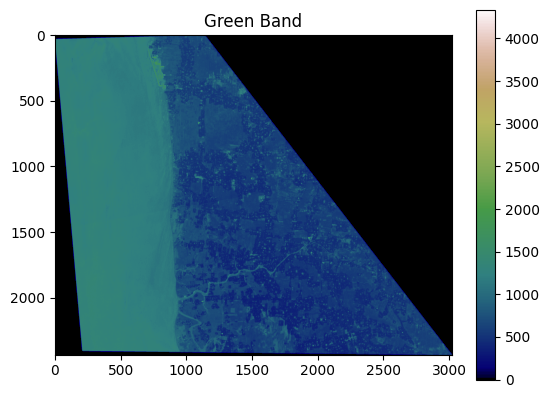

In [ ]:
# Plot the green band using a non-default colour map & a colour bar
# see also: https://matplotlib.org/stable/tutorials/colors/colormaps.html

fig = plt.imshow(band_green)
fig.set_cmap('gist_earth')
plt.colorbar()
plt.title("Green Band")
plt.show()


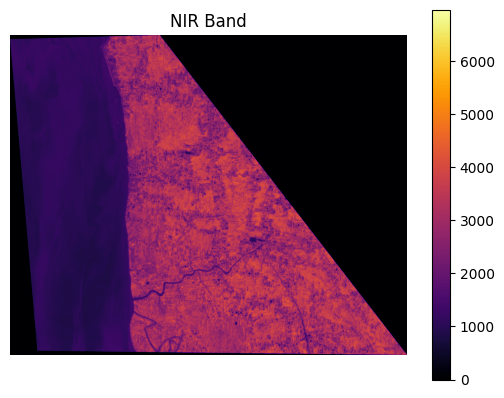

In [ ]:
# Plot the nir band as red 
fig = plt.imshow(band_nir)
fig.set_cmap('inferno')
plt.colorbar()
plt.title("NIR Band")

# Since the axis labels are useless here, let's turn them off.  --Q: why is this useless?
plt.axis('off')

# Display the results.
plt.show()

# Compose scene using visual imagery

Create a function to compose a scene, given red, green, and blue bands from PlanetScope Visual products.

Q: What is the definition of scene?


In [ ]:
def compose_scene(image_filename):
    """
    Extracts red, green, and blue bands from a PlanetScope Visual product and
    stacks them to compose a scene.

    Parameters:
    -----------
        image_filename : str
                     The path to a PlanetScope 4-Band image.
    
    Returns:
    --------
        band_red :   Array[int]
                     Red band image.
        band_green : Array[int]
                     Green band image.
        band_blue :  Array[int]
                     Blue band image.

    """

    #Extract visual imagery RGB
    with rasterio.open(image_filename) as src:
        band_blue = src.read(1)
    with rasterio.open(image_filename) as src:
        band_green = src.read(2)
    with rasterio.open(image_filename) as src:
        band_red = src.read(3)
    
    # Stack the 3 bands to create an RGB visual image
    #dstack: Stack arrays in sequence depth wise (along third axis).
    visual_image = np.dstack((band_blue,band_green, band_red))

    return visual_image




Text(0.5, 1.0, '2018 visual image')

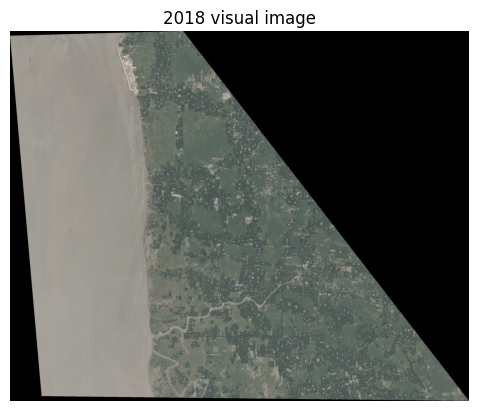

In [ ]:
# Extract visual images 
visual_image = compose_scene(visual_filenames[n])

plt.imshow(visual_image)
plt.axis('off')
plt.title("2018 visual image")


# Compute the Normalized Difference Water Index (NDWI)

This function will measure the normalized difference water index (NDWI), defined as: NDWI = green- NIR /green + NIR

Please note that this requires that both the green and NIR imagery are normalized, which has already been done in the data processing pipeline for the Analytic Surface Reflectance data we're using.



In [ ]:
def measure_ndwi (band_green,band_nir):
    """
    Computes the normalized difference water index (NDWI).

    Parameters:
    -----------
        band_green : Array[int]
               Normalized green band image.
        band_nir : Array[int]
               Normalized NIR band image.
    
    Returns:
    --------
        ndwi : Array[float]
               Normalized difference water index. 
    """
     # Allow division by zero -- why?
    np.seterr(divide='ignore', invalid='ignore')

     # Calculate NDWI
    ndwi = (band_green.astype(float)  - band_nir.astype(float) )/ (band_green +band_nir )

    return ndwi


Now, let's use our analytic imagery to compute the NDWI, which will help us determine which pixels are associated with water and which are associated with land.



Text(0.5, 1.0, '2018 NDWI Values')

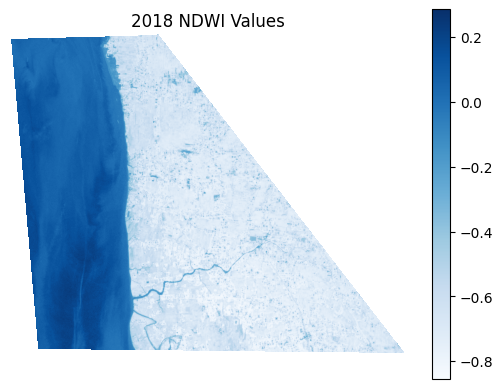

In [ ]:
# Compute NDWI
ndwi = measure_ndwi(band_green, band_nir)

#visualize 
fig = plt.imshow(ndwi)
fig.set_cmap('Blues')
plt.axis('off')
plt.colorbar()
plt.title("2018 NDWI Values")

Notice how the strip of coastline on the right side of the AOI has relatively low NDWI values and the water on the left has relatively high NDWI values?

# Use NDWI to find Find water and land pixels
NDWI values range from -1 to +1. Pixels which have a relatively high NDWI value (NDWI >= 0.3) are likely to be associated with water, whereas pixels with values under this threshold (NDWI < 0.3) are unlikely to be associated with water.

In [ ]:
def find_water_and_land(ndwi):
    """
    Given an NDWI image, return a mask with pixels associated with water and
    another mask with pixels associated with land.

    Parameters:
    -----------
        ndwi : Array[float]
               Normalized difference water index.
    
    Returns:
    --------
        water_mask : Array[int]
               A binary mask for water.
        land_mask :  Array[int]
               A binary mask for land.
    """

    # Although the water threshold is NDWI >= 0.3
    # we'll set it lower to account of murky waters
    WATER_THRESHOLD = 0.0

    # Create arrays of NANs
    water_mask = np.full(ndwi.shape, np.nan)
    land_mask = np.full(ndwi.shape, np.nan)

    # Threshold the NDWI image and create water & land masks
    water_mask[ndwi >= WATER_THRESHOLD ] =1
    land_mask[ndwi < WATER_THRESHOLD ] =1

    return water_mask,land_mask

    


In [ ]:
# Create water and land masks from the NDWI array
#Note: NANs represent regions of the maps that have been clipped.
water_mask, land_mask = find_water_and_land(ndwi)
print(land_mask)

NameError: name 'ndwi' is not defined

In [ ]:
#Now, let's visualize these water and land mask arrays as maps!

plt.figure(0)
plt.imshow(water_mask)
plt.axis('off')
plt.title("2018 water mask")

plt.figure(1)
plt.imshow(land_mask)
plt.axis('off')
plt.title("2018 land mask")

NameError: name 'water_mask' is not defined

<Figure size 640x480 with 0 Axes>

While this masking is helpful in distingushing water from land, notice the holes in the water & land? " In the water mask, it is likely due to the fact that we are imaging especially murky water with either excessive vegetation growth, or perhaps these pixels are associated with sandbars off of the coast! For the land mask, we are likely picking up small bodies of water inland."

For our coastline analysis, we only care about where the water meets the land, so it would be most helpful for us to have clean distinctions between what is "mostly land" to what is "mostly water”. Specifically, we want to create a mask for the ocean and a mask for the land. We can do this by applying morphological filters to clean up our pixel classification.

# Apply Filters
We can apply morphological filters to filter out the unwanted pixels in the water and land masks. We use a closing filter to close small clusters of pixels (e.g., holes) inside parts of a mask. Following, we use an opening filter to remove any small clusters of pixels outside a mask.

In [ ]:
def filter_mask(closing_kernel_size, opening_kernel_size, mask):
    """
    Given a mask, apply morphological filters (closing followed by opening) 
    to filter out unwanted pixels.

    Parameters:
    -----------
       closing_kernel_size : Int
                             Size of the closing kernel in pixels.
       opening_kernel_size : Int
                             Size of the opening kernel in pixels.
        mask : Array[int]
               A binary mask.
    
    Returns:
    --------
        mask_closed_opened : Array[int]
               A morphologically filtered binary mask.
    """

    ## Closing filter: Remove empty pixels within mask
    # Create a kernel element which is closing_kernel_size^2 in size
    closing_kernel_element = (closing_kernel_size, closing_kernel_size)
    # Create a closing filter kernel
    closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                               closing_kernel_element)
    # Apply closing filter to input mask
    mask_closed = cv2.morphologyEx(np.nan_to_num(mask), cv2.MORPH_CLOSE,
                                   closing_kernel)

    ## Opening filter: Removing filled pixels outside of mask
    # Create a kernel element which is closing_kernel_size^2 in size
    opening_kernel_element = (opening_kernel_size, opening_kernel_size)
    # Create an opening filter kernel
    opening_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                               opening_kernel_element)
    # Apply opening filter to closed mask
    mask_closed_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN,
                                          opening_kernel)

    # Ensure the clipped areas remain clipped
    mask_closed_opened[mask_closed_opened == 0] = np.nan

    return mask_closed_opened

In [ ]:
#Let's see how this works in practice. Let's apply these morphological filters to both the water and land masks. These kernel sizes were chosen by empirical observations. To put them in physical units, multiply them by the pixel size (~3.7m / px).

# Filter the water mask
CLOSING_KERNEL_SIZE = 29
OPENING_KERNEL_SIZE = 13
water_mask_filtered = filter_mask(CLOSING_KERNEL_SIZE, OPENING_KERNEL_SIZE,
                                  water_mask)

# Filter the land mask
CLOSING_KERNEL_SIZE = 3
OPENING_KERNEL_SIZE = 101
land_mask_filtered = filter_mask(CLOSING_KERNEL_SIZE, OPENING_KERNEL_SIZE,
                                 land_mask)

NameError: name 'water_mask' is not defined